# Time Series Forecasting with Linear Learner
_** 본문은 aws sagemaker 영문 samples 에서 레퍼런스하였습니다. (ref: https://github.com/aws/amazon-sagemaker-examples/tree/master/introduction_to_applying_machine_learning/linear_time_series_forecast) **_

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Forecast](#Forecast)


## Background

시계열 예측은 잠재적으로 가장 관련성이 높은 기계 학습 주제입니다. 소매업의 미래 판매, 부동산 주택 가격, 도시 교통, 의료 분야의 환자 방문 등 거의 모든 산업에서 시계열 예측 개선의 이점을 얻을 수 있습니다.시계열 데이터를 예측하기 위해 개발된 수많은 통계 방법론이 있지만 여전히 예측 개발 프로세스는 객관적인 통계와 주관적인 해석이 혼합된 경향이 있습니다.

시계열 데이터를 적절하게 모델링하려면 많은 주의가 필요합니다. 모델링에 적합한 집계 수준은 무엇일까요? 너무 세분화되고 노이즈 때문에 신호가 손실되고, 중요한 변화가 누락됩니다. 또한 올바른 주기성은 무엇일까요?매일, 매주, 매월? 휴일 데이터는 존재하나요? 최근 동향과 전반적인 추세를 어떻게 가중시켜야 할까요?

추세, 계절성 및 최근 동작에 대한 적절한 컨트롤을 사용한 선형 회귀 분석은 합리적인 변동성으로 안정적인 시계열을 예측하는 일반적인 방법입니다. 이 노트북은 1991년부터 2005년까지 미국 가솔린 제품의 주간 생산량을 예측하는 선형 모델을 구축합니다. 거의 독점적으로 응용 프로그램에 초점을 맞출 것입니다. 예측에 대한 자세한 내용은 예측: 원칙 및 실습을 참조하십시오. 또한 데이터 집합은 단일 시계열이므로 SageMaker의 선형 학습자 알고리즘을 고수할 것입니다. 관련 시계열이 여러 개 있는 경우 예측을 위해 특별히 설계된 SageMaker의 DeepAR 알고리즘을 사용합니다. 자세한 내용은 DeepAR 노트북을 참조하십시오.

## Setup

본 노트북은 다음 인스턴스 타입에서 실행되었습니다.
* ml.m5.2xlarge

다음을 지정하여 시작해 보겠습니다.

* 학습 및 모델 데이터에 사용할 S3 버킷과 prefix 입니다. 이 노트북 인스턴스, 교육 및 호스팅과 동일한 region 내에 있어야 합니다.
* 데이터에 대한 교육 및 호스팅 액세스를 제공하는 데 사용되는 IAM 역할 arn입니다. 이러한 항목을 만드는 방법은 설명서를 참조하십시오. 노트북 인스턴스, 교육 및/또는 호스팅에 둘 이상의 역할이 필요한 경우 boto 정규 표현식을 적절한 전체 IAM 역할 arn 문자열로 교체하십시오.

In [2]:
import sagemaker

# Default S3 bucket created for training and storing model artifacts
# The bucket and prefix parameters can be modified to use an existing bucket
# 버켓 이름은 사용자 지정으로 바꿀수 있습니다.
# bucket = sagemaker.Session().default_bucket()
bucket = "yudong-data"
prefix = "sagemaker/linear-time-series-forecast"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [3]:
role

'arn:aws:iam::806174985048:role/service-role/AmazonSageMaker-ExecutionRole-20201218T151409'

이제 필요한 Python 라이브러리를 가져옵니다.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import sagemaker.amazon.common as smac
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

## Data 

데이터를 다운받습니다. 데이터에 대한 자세항 정보는 다음 링크를 참조하십시오. [여기](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [5]:
!wget http://robjhyndman.com/data/gasoline.csv

--2021-05-23 11:47:00--  http://robjhyndman.com/data/gasoline.csv
Resolving robjhyndman.com (robjhyndman.com)... 35.208.79.31
Connecting to robjhyndman.com (robjhyndman.com)|35.208.79.31|:80... ^C


In [6]:
raw_df = pd.read_csv('gasoline.csv')

In [7]:
raw_df.head()

,6621
0,6433.0
1,6582.0
2,7224.0
3,6875.0
4,6947.0


<AxesSubplot:>

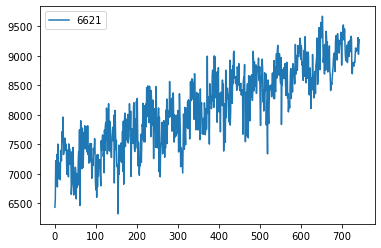

In [8]:
raw_df.plot()

보시다시피, 확실한 상승 추세가 있고, 계절성이 존재하고, 충분한 변동성이 있습니다.
몇 가지 예기치 않은 딥과 계절성이 다소 뚜렷한 몇 년이 있습니다. 이러한 특성은 많은 시계열에서 일반적입니다.

In [9]:
gas = pd.read_csv("gasoline.csv", header=None, names=["thousands_barrels"])

In [10]:
gas.head()

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


다음으로 데이터 집합을 변환하여 표준 예측 모델과 좀 더 비슷하게 보이게 할 것입니다. 우리의 대상 변수는 천개 단위의 배럴입니다. 다음과 같은 feature 들을 만들어 보겠습니다.

* 4주 이전의 배럴 양
* trend. 위의 차트는 추세가 단순히 선형임을 나타내지만 로그와 quadric trend 를 만들어 줍니다.
* 계절 및 주요 휴일 주를 파악하는 데 도움이 되는 지표 변수 {0 또는 1} 입니다.

In [11]:
gas["thousands_barrels_lag1"] = gas["thousands_barrels"].shift(1)
gas["thousands_barrels_lag2"] = gas["thousands_barrels"].shift(2)
gas["thousands_barrels_lag3"] = gas["thousands_barrels"].shift(3)
gas["thousands_barrels_lag4"] = gas["thousands_barrels"].shift(4)
gas["trend"] = np.arange(len(gas))
gas["log_trend"] = np.log1p(np.arange(len(gas)))
gas["sq_trend"] = np.arange(len(gas)) ** 2
weeks = pd.get_dummies(np.array(list(range(52)) * 15)[: len(gas)], prefix="week")
gas = pd.concat([gas, weeks], axis=1)

In [33]:
gas.head(10)

,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_45,week_46,week_47,week_48,week_49,week_50,week_51,thousands_barrels_lag52,thousands_barrels_lag104,thousands_barrels_naive_forecast
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
5,6947.0,6875.0,7224.0,6582.0,6433.0,5,1.791759,25,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
6,7328.0,6947.0,6875.0,7224.0,6582.0,6,1.945910,36,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
7,6777.0,7328.0,6947.0,6875.0,7224.0,7,2.079442,49,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
8,7503.0,6777.0,7328.0,6947.0,6875.0,8,2.197225,64,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
9,6916.0,7503.0,6777.0,7328.0,6947.0,9,2.302585,81,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
10,7045.0,6916.0,7503.0,6777.0,7328.0,10,2.397895,100,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
11,6956.0,7045.0,6916.0,7503.0,6777.0,11,2.484907,121,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
12,6976.0,6956.0,7045.0,6916.0,7503.0,12,2.564949,144,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
13,7185.0,6976.0,6956.0,7045.0,6916.0,13,2.639057,169,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


이제, 우리는 다음과 같이 할 것입니다.
- lagged information 이 없는 처음 네 행을 지웁니다.
- explanatory features 에서 target 을 분리합니다.
- 데이터를 교육, 검증 및 테스트 그룹으로 분할하여 모델을 조정한 다음 아직 보지 못한 데이터에 대한 정확성을 평가할 수 있습니다.이 데이터는 시계열 데이터이므로 첫 번째 60% 를 교육에 사용하고 두 번째 20% 는 검증에 사용하고 최종 테스트 평가에는 최종 20% 를 사용합니다.

In [13]:
gas = gas.iloc[
    4:,
]
split_train = int(len(gas) * 0.6)
split_test = int(len(gas) * 0.8)

train_y = gas["thousands_barrels"][:split_train]
train_X = (
    gas.drop("thousands_barrels", axis=1)
    .iloc[
        :split_train,
    ]
    .to_numpy()
)
validation_y = gas["thousands_barrels"][split_train:split_test]
validation_X = (
    gas.drop("thousands_barrels", axis=1)
    .iloc[
        split_train:split_test,
    ]
    .to_numpy()
)
test_y = gas["thousands_barrels"][split_test:]
test_X = (
    gas.drop("thousands_barrels", axis=1)
    .iloc[
        split_test:,
    ]
    .to_numpy()
)

In [32]:
train_y

4      6875.0
5      6947.0
6      7328.0
7      6777.0
8      7503.0
        ...  
443    8644.0
444    8519.0
445    8415.0
446    8810.0
447    8778.0
Name: thousands_barrels, Length: 444, dtype: float64

이제 데이터 세트를 Amazon SageMaker 알고리즘에서 사용하는 recordIO-wrapped protobuf 형식으로 변환합니다.

In [16]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(
    buf, np.array(train_X).astype("float32"), np.array(train_y).astype("float32")
)
buf.seek(0)

0

In [17]:
key = "linear_train.data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
print("uploaded training data location: {}".format(s3_train_data))

uploaded training data location: s3://yudong-data/sagemaker/linear-time-series-forecast/train/linear_train.data


In [18]:

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(
    buf, np.array(validation_X).astype("float32"), np.array(validation_y).astype("float32")
)
buf.seek(0)

0

In [19]:
key = "linear_validation.data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "validation", key)).upload_fileobj(
    buf
)
s3_validation_data = "s3://{}/{}/validation/{}".format(bucket, prefix, key)
print("uploaded validation data location: {}".format(s3_validation_data))

uploaded validation data location: s3://yudong-data/sagemaker/linear-time-series-forecast/validation/linear_validation.data


### Train

이제 선형 모델을 지정할 수 있습니다. 먼저 linear learner 알고리즘에 대한 컨테이너를 지정해 보겠습니다. 이 노트북이 Amazon SageMaker의 모든 지역에서 실행되기를 원하기 때문에 편리한 기능을 사용하여 현재 지역의 컨테이너 이미지 이름을 찾습니다. 알고리즘 컨테이너에 대한 자세한 내용은 다음에서 확인하실 수 있습니다. [AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [20]:
from sagemaker.amazon.amazon_estimator import image_uris

container = image_uris.retrieve(framework="linear-learner", region=boto3.Session().region_name)

In [21]:
container

'835164637446.dkr.ecr.ap-northeast-2.amazonaws.com/linear-learner:1'

Amazon SageMaker의 Linear Learner는 실제로 여러 모델에 병렬로 적합하며 각 모델마다 약간 다른 하이퍼파라미터가 있는 다음 가장 적합한 모델을 반환합니다. 이 기능은 자동으로 활성화됩니다. 다음과 같은 매개 변수를 사용하여 영향을 줄 수 있습니다.

-num_models: 실행 모델의 총 수. 지정된 매개 변수는 항상 이러한 모델 중 하나이지만 알고리즘은 가까운 매개 변수 값이 있는 모델을 선택하여 보다 최적의 솔루션을 찾습니다.
-loss: 모델 견적에서 실수를 제어하는 파라미터. 데이터를 정리하는 데 많은 시간을 소비하지 않았기 때문에 absolute_loss 를 사용합니다. absolute_loss 는 아웃라이어에 덜 반응합니다.


In [ ]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
linear.set_hyperparameters(
    feature_dim=59,
    mini_batch_size=100,
    predictor_type="regressor",
    epochs=10,
    num_models=32,
    loss="absolute_loss",
)

linear.fit({"train": s3_train_data, "validation": s3_validation_data})

---
## Host
학습이 끝난 모델은 배포를 합니다.

In [23]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

---------------!

### Forecast

시계열의 모델을 평가하는 지표는 대표적으로 다음과 같습니다:

- Root Mean Square Error (RMSE)
- Mean Absolute Percent Error (MAPE)
- Geometric Mean of the Relative Absolute Error (GMRAE)
- Quantile forecast errors
- Errors that account for asymmetric loss in over or under-prediction

이 예에서는 간단한 작업을 유지하고 Median Absolute Percent Error (MdAPE) 를 사용하지만 Naive Benchmark forecast (지난해 그 주 수요* 지난해 해당 주/2년 전 해당 주) 과 비교하겠습니다.


In [24]:
gas["thousands_barrels_lag52"] = gas["thousands_barrels"].shift(52)
gas["thousands_barrels_lag104"] = gas["thousands_barrels"].shift(104)
gas["thousands_barrels_naive_forecast"] = (
    gas["thousands_barrels_lag52"] ** 2 / gas["thousands_barrels_lag104"]
)
naive = gas[split_test:]["thousands_barrels_naive_forecast"].to_numpy()

Naive MdAPE = 0.03687277085962615


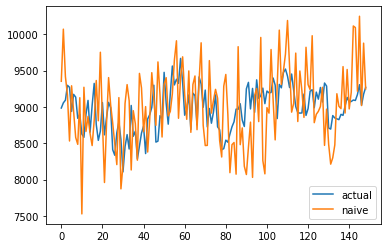

In [25]:
print("Naive MdAPE =", np.median(np.abs(test_y - naive) / test_y))
plt.plot(np.array(test_y), label="actual")
plt.plot(naive, label="naive")
plt.legend()
plt.show()

먼저 numpy 배열을 추론 컨테이너에 전달하는 HTTP POST 요청으로 처리 할 수있는 형식으로 변환하는 함수가 필요합니다. 이 예제는 간단한 CSV 문자열입니다. 결과는 JSON으로 다시 변환됩니다. 이러한 포멧의 경우 AWS SageMaker Python SDK의 내장 CSVSerializer 및 JSONDeserializer 함수를 사용할 수 있습니다.

In [26]:
linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

In [27]:
result = linear_predictor.predict(test_X)
one_step = np.array([r["score"] for r in result["predictions"]])

One-step-ahead MdAPE =  0.020360223119258346


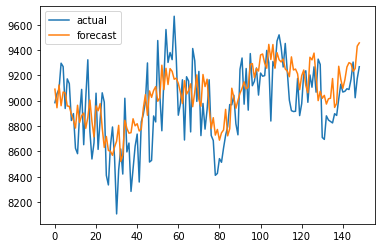

In [28]:
print("One-step-ahead MdAPE = ", np.median(np.abs(test_y - one_step) / test_y))
plt.plot(np.array(test_y), label="actual")
plt.plot(one_step, label="forecast")
plt.legend()
plt.show()

In [29]:
multi_step = []
lags = test_X[0, 0:4]
for row in test_X:
    row[0:4] = lags
    result = linear_predictor.predict(row)
    prediction = result["predictions"][0]["score"]
    multi_step.append(prediction)
    lags[1:4] = lags[0:3]
    lags[0] = prediction

multi_step = np.array(multi_step)

Multi-step-ahead MdAPE = 0.021905220272206302


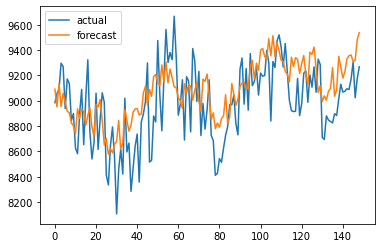

In [30]:
print("Multi-step-ahead MdAPE =", np.median(np.abs(test_y - multi_step) / test_y))
plt.plot(np.array(test_y), label="actual")
plt.plot(multi_step, label="forecast")
plt.legend()
plt.show()